# 8. GNN Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dgl
import dgl.nn as dglnn
from dgl.data.utils import load_graphs

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv

from sklearn.preprocessing import StandardScaler

# Load Customers Graph

In [2]:
g = load_graphs('customers_graph')[0][0]
g

Graph(num_nodes={'customer': 126183, 'external': 69875},
      num_edges={('customer', 'cc_self', 'customer'): 126183, ('customer', 'cec', 'customer'): 122064, ('customer', 'cee', 'external'): 73545, ('customer', 'cwc', 'customer'): 14668, ('customer', 'cwe', 'external'): 12780, ('external', 'ee_self', 'external'): 69875, ('external', 'eec', 'customer'): 123291, ('external', 'ewc', 'customer'): 20844},
      metagraph=[('customer', 'customer', 'cc_self'), ('customer', 'customer', 'cec'), ('customer', 'customer', 'cwc'), ('customer', 'external', 'cee'), ('customer', 'external', 'cwe'), ('external', 'external', 'ee_self'), ('external', 'customer', 'eec'), ('external', 'customer', 'ewc')])

In [3]:
g.ntypes

['customer', 'external']

In [4]:
g.etypes

['cc_self', 'cec', 'cee', 'cwc', 'cwe', 'ee_self', 'eec', 'ewc']

In [5]:
g.canonical_etypes

[('customer', 'cc_self', 'customer'),
 ('customer', 'cec', 'customer'),
 ('customer', 'cee', 'external'),
 ('customer', 'cwc', 'customer'),
 ('customer', 'cwe', 'external'),
 ('external', 'ee_self', 'external'),
 ('external', 'eec', 'customer'),
 ('external', 'ewc', 'customer')]

In [6]:
g.num_nodes()

196058

In [7]:
g.num_edges()

563250

# Build RGCN

We will now build a GNN to produce embeddings for each node so that we can cluster the nodes into communities. By doing so, we can then detect communities or find subgraphs from the customers graph.

### Define HeteroGNN

In [8]:
class HeteroGNN(nn.Module):
    def __init__(self, g, in_dim, common_dim, out_dim, agg_type):
        super(HeteroGNN, self).__init__()
        self.g = g
        self.in_dims = in_dim
        self.common_dim = common_dim
        self.out_dim = out_dim
        self.agg_type = agg_type
        
        # Transform node features to common dimension for each node type
        self.node_transforms = nn.ModuleDict({
            ntype: nn.Linear(feat_dim, out_dim) for ntype, feat_dim in in_dim.items()
        })
     
        # Add 2 GNN layers --> HGConv Layers with SAGEConv
        self.gnn_layers = nn.ModuleList([
            dglnn.HeteroGraphConv({
                etype: dglnn.SAGEConv(common_dim, common_dim, agg_type, feat_drop=0.1)
                for etype in g.etypes
            }, aggregate='sum')
            for _ in range(2)
        ])
        
        # Output layer for each node type
        self.output_layers = nn.ModuleDict({
            ntype: nn.Linear(common_dim, out_dim) for ntype in g.ntypes
        })
    
    def forward(self, g, node_fts):
        t_nfeats = {}
        
        # Transform node features
        for ntype, features in node_fts.items():
            if ntype in self.node_transforms:
                t_nfeats[ntype] = self.node_transforms[ntype](features)
        
        h = t_nfeats
        
        # Apply GNN layers
        for gnn_layer in self.gnn_layers:
            h = gnn_layer(g, h)
        
        # Apply output layers
        return {ntype: self.output_layers[ntype](h[ntype]) for ntype in self.g.ntypes}

# Optimization using Attribute Masking

In [9]:
def create_node_mask(num_nodes, mask_ratio):
    # Randomly generate a mask with the given ratio
    mask = torch.rand(num_nodes) < mask_ratio
    return mask

In [10]:
def mask_node_features(features, mask):
    # Clone to avoid modifying the original features
    masked_features = features.clone()  
    
    # Set all features of masked nodes to zero
    masked_features[mask] = 0 
    return masked_features

In [11]:
def attribute_masking_loss(model, g, features, mask_ratio=0.1):
    masked_fts = {}
    mask_loss = 0
    masks = {}
    for ntype, fts in features.items():
        num_nodes = fts.size(0)
        
        # Create a node mask
        node_mask = create_node_mask(num_nodes, mask_ratio)
        
        # Store the mask to use later
        masks[ntype] = node_mask 
        
        # Apply the mask to node features
        masked_fts[ntype] = mask_node_features(fts, node_mask).detach()
        
    # Get predictions
    predictions = model(g, masked_fts)

    # Calculate reconstruction loss for each node type individually
    for ntype, fts in features.items():
        # Make sure predictions and features are correctly indexed by node type
        if ntype in predictions:
            detached_predictions = predictions[ntype].detach()
            loss = F.mse_loss(detached_predictions[masks[ntype]], fts[[masks[ntype]]])
            mask_loss += loss
            
    return mask_loss / len(features)  # Average loss across node types

# Split Train Test Sets

### Get training node masks

In [12]:
# Get num nodes for each type
num_cnodes = g.number_of_nodes('customer')
num_enodes = g.number_of_nodes('external')

In [13]:
# Set the percentage of nodes to use as training
train_ratio = 0.8

# Create random indices for each node type
index_c = torch.randperm(num_cnodes)
index_e = torch.randperm(num_enodes)

# Calculate the number of training nodes for each type
num_train_c = int(num_cnodes * train_ratio)
num_train_e = int(num_enodes * train_ratio)

# Generate the training masks
tmask_c = torch.zeros(num_cnodes, dtype=torch.bool)
tmask_e = torch.zeros(num_enodes, dtype=torch.bool)

tmask_c[index_c[:num_train_c]] = True
tmask_e[index_e[:num_train_e]] = True

In [14]:
# store the masks in a dictionary 
train_masks = {}
train_masks['customer'] = tmask_c
train_masks['external'] = tmask_e
train_masks

{'customer': tensor([ True,  True,  True,  ...,  True, False,  True]),
 'external': tensor([False,  True,  True,  ...,  True,  True, False])}

In [15]:
# Get test masks
test_masks = {ntype: ~train_masks[ntype] for ntype in g.ntypes}
test_masks

{'customer': tensor([False, False, False,  ..., False,  True, False]),
 'external': tensor([ True, False, False,  ..., False, False,  True])}

### Get training and testing graphs

In [16]:
# Create clones of the original graph
train_g = g.clone()
test_g = g.clone()

In [17]:
# Get the training/test graph
train_g = dgl.node_subgraph(train_g, train_masks)
test_g = dgl.node_subgraph(test_g, test_masks)

In [18]:
train_g.ndata['features']['external'].shape

torch.Size([55900, 30])

# Transform Node Feature Dimension

The feature dimension for the two types of nodes, customer and external, are different, therefore, we need to transform the feature tensors into a common dimension before passing it to the convolutional layers. The following class is used to transform the node feature dimensions.

In [19]:
class FeatureTransform(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(FeatureTransform, self).__init__()
        
        # Transform node features to common dimension for each node type
        self.node_transforms = nn.ModuleDict({
            ntype: nn.Linear(feat_dim, out_dim) for ntype, feat_dim in in_dim.items()
        })
    
    def forward(self, node_features):
        t_nfeats = {}
        
        # Transform node features
        for ntype, features in node_features.items():
            if ntype in self.node_transforms:
                t_nfeats[ntype] = self.node_transforms[ntype](features)

        return t_nfeats

In [20]:
# Create a function to apply the transformation to a given graph
def apply_transform(g):
    """
    """
    # create a dictionary to store the node features
    node_fts = {ntype: g.nodes[ntype].data['features'] for ntype in g.ntypes}
    
    # create a dictionary to store the node feature dimensions for each node type
    in_dims = {ntype: g.nodes[ntype].data['features'].shape[1] for ntype in g.ntypes}
    
    # Transform node features to common dimension
    transform = FeatureTransform(in_dims, 42)
    new_node_fts = transform(node_fts)
    
    # return the transformed node features
    return new_node_fts

### Apply transformation to training graph

In [21]:
# Apply transformation to training graph and get the new in_dims
new_train_fts = apply_transform(train_g)
new_train_fts

{'customer': tensor([[-1.5960e+01,  6.5264e+02,  6.5886e+02,  ...,  2.8117e+02,
           3.6349e+01, -1.0107e+03],
         [ 1.8730e+01,  4.7660e-01, -1.6409e+01,  ..., -1.8687e+00,
           1.7417e+01, -5.1243e+00],
         [-2.4683e+03,  3.5807e+03, -5.0532e+03,  ..., -3.9863e+03,
          -2.8434e+03, -5.1597e+03],
         ...,
         [ 4.6836e+02,  1.1445e+03,  4.9761e+01,  ...,  1.0212e+03,
          -1.3393e+03,  3.8133e+02],
         [ 8.6206e+01,  3.6497e+01, -1.3027e+02,  ..., -3.7939e+01,
           3.9040e+01, -2.1812e+01],
         [-3.0980e+01,  6.8973e+01,  6.7473e+01,  ...,  6.1520e+01,
           2.2752e+01, -1.2111e+02]], grad_fn=<AddmmBackward0>),
 'external': tensor([[ 1.7236e+02, -7.5190e+01, -2.1428e+01,  ...,  2.0650e+01,
           8.3039e+01,  9.5497e+01],
         [ 1.4911e+02, -2.0069e+01,  7.2495e+01,  ..., -8.0769e+01,
          -5.6538e+01,  3.8067e+01],
         [ 9.5124e+02,  8.2099e+01, -7.4836e+02,  ..., -6.5200e+02,
           1.9513e+02,  3.

In [22]:
# Get the new dimensions for the training graph
new_train_dims = {k: v.shape[1] for k,v in new_train_fts.items()}
new_train_dims 

{'customer': 42, 'external': 42}

### Apply transformation to testing graph

In [23]:
# Apply transformation to test graph and get the new in_dims
new_test_fts = apply_transform(test_g)
new_test_fts

{'customer': tensor([[   26.3220,   -16.5975,    -6.6489,  ...,    20.2469,   -24.4931,
              3.3990],
         [-2077.9924, -1325.9006, -1217.4636,  ...,  -313.2578,    99.1838,
            523.2397],
         [ -380.5975,  -110.6291,   132.0687,  ...,  -144.6467,   -75.5067,
            106.2134],
         ...,
         [   10.8305,   -25.0364,   -11.6678,  ...,    17.1416,   -11.4137,
             55.8818],
         [    3.2429,    28.6428,    60.1273,  ...,    73.9395,   -24.6393,
             57.2959],
         [ -423.4360,  -152.9532,   161.0216,  ...,  -140.7456,  -119.7382,
             42.4240]], grad_fn=<AddmmBackward0>),
 'external': tensor([[228.0441, 257.1777, 208.3454,  ..., 259.5993,  59.8399, 197.6290],
         [123.1034, 135.3996, 106.0291,  ..., 314.2817, 125.6488, 110.5306],
         [862.6603, 979.2479, 789.8278,  ..., 983.2619, 230.9511, 746.1061],
         ...,
         [ 34.9323,  -7.7604, -35.8651,  ...,  33.5211,  38.2979,  58.9721],
         [-40.4583

In [24]:
# Get the new dimensions for the testing graph
new_test_dims = {k: v.shape[1] for k,v in new_test_fts.items()}
new_test_dims 

{'customer': 42, 'external': 42}

# Train Model 

Train model using train_g and evaluate performance on test_g.

In [25]:
def evaluate(model, g, features):
    model.eval()
    with torch.no_grad():
        loss = attribute_masking_loss(model, g, features)
    return loss

In [26]:
# Track loss
best_val_loss = float('inf')

In [27]:
# Create lists to store the losses for plotting
train_losses = []
test_losses = []

In [28]:
# Initiate model
model = HeteroGNN(train_g, new_train_dims, common_dim=42, out_dim=42, agg_type='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

for epoch in range(100):
    # Train the model
    model.train()
    optimizer.zero_grad()
    loss = attribute_masking_loss(model, train_g, new_train_fts)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Store the training loss
    train_losses.append(loss.item())
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Evaluate on the test set
    val_loss = evaluate(model, test_g, new_test_fts)
    
    # Store the test loss
    test_losses.append(val_loss.item())
    print(f"Epoch {epoch}, Test Loss: {val_loss.item()}")
    
    # Checkpointing the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")

Epoch 0, Loss: 8523796.0
Epoch 0, Test Loss: 2907590.75
Saved new best model
Epoch 1, Loss: 8835002.0
Epoch 1, Test Loss: 3275320.0
Epoch 2, Loss: 8416380.0
Epoch 2, Test Loss: 3194568.0
Epoch 3, Loss: 7956960.0
Epoch 3, Test Loss: 2986394.0
Epoch 4, Loss: 8126125.5
Epoch 4, Test Loss: 3090827.5
Epoch 5, Loss: 7936227.0
Epoch 5, Test Loss: 3421765.0
Epoch 6, Loss: 8880906.0
Epoch 6, Test Loss: 3135504.0
Epoch 7, Loss: 9041500.0
Epoch 7, Test Loss: 3549744.75
Epoch 8, Loss: 8472712.0
Epoch 8, Test Loss: 3265718.5
Epoch 9, Loss: 8166681.0
Epoch 9, Test Loss: 3362776.0
Epoch 10, Loss: 11421682.0
Epoch 10, Test Loss: 3621485.5
Epoch 11, Loss: 7992294.5
Epoch 11, Test Loss: 3913351.5
Epoch 12, Loss: 8272961.0
Epoch 12, Test Loss: 3155087.25
Epoch 13, Loss: 7945114.0
Epoch 13, Test Loss: 3100336.75
Epoch 14, Loss: 10945242.0
Epoch 14, Test Loss: 3345609.5
Epoch 15, Loss: 8142507.0
Epoch 15, Test Loss: 3547271.5
Epoch 16, Loss: 8854225.0
Epoch 16, Test Loss: 2982541.0
Epoch 17, Loss: 8583421.

# Plot the Losses

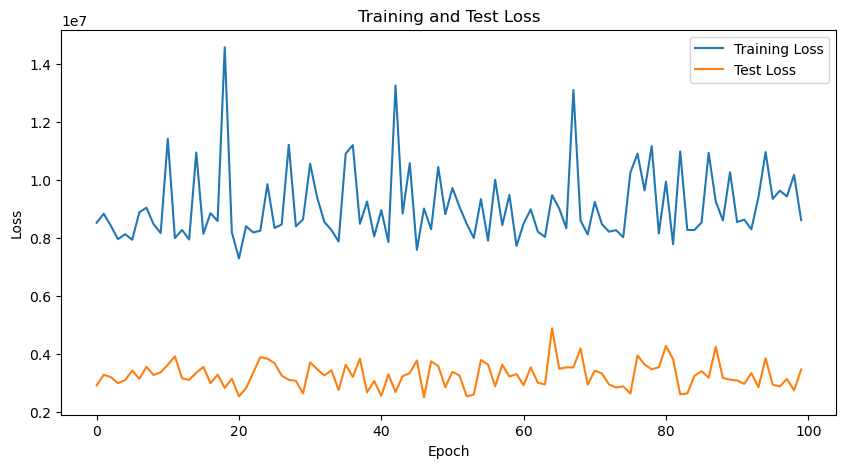

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

### Training with 'lstm' agg

In [30]:
# Create lists to store the losses for plotting
lstm_train_losses = []
lstm_test_losses = []

In [31]:
# Initiate model
model = HeteroGNN(train_g, new_train_dims, common_dim=42, out_dim=42, agg_type='lstm')
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

for epoch in range(100):
    # Train the model
    model.train()
    optimizer.zero_grad()
    loss = attribute_masking_loss(model, train_g, new_train_fts)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Store the training loss
    train_losses.append(loss.item())
    lstm_train_losses.append(loss.item())
    print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    # Evaluate on the test set
    val_loss = evaluate(model, test_g, new_test_fts)
    
    # Store the test loss
    test_losses.append(val_loss.item())
    lstm_test_losses.append(val_loss.item())
    print(f"Epoch {epoch}, Test Loss: {val_loss.item()}")
    
    # Checkpointing the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")

Epoch 0, Loss: 605604.75
Epoch 0, Test Loss: 1014765.625
Saved new best model
Epoch 1, Loss: 597690.875
Epoch 1, Test Loss: 756558.125
Saved new best model
Epoch 2, Loss: 521921.125
Epoch 2, Test Loss: 649967.25
Saved new best model
Epoch 3, Loss: 557817.4375
Epoch 3, Test Loss: 781573.375
Epoch 4, Loss: 538550.1875
Epoch 4, Test Loss: 565115.4375
Saved new best model
Epoch 5, Loss: 694645.125
Epoch 5, Test Loss: 533628.0
Saved new best model
Epoch 6, Loss: 650102.5
Epoch 6, Test Loss: 513833.34375
Saved new best model
Epoch 7, Loss: 607939.5
Epoch 7, Test Loss: 509862.1875
Saved new best model
Epoch 8, Loss: 824817.25
Epoch 8, Test Loss: 757338.625
Epoch 9, Loss: 567056.0625
Epoch 9, Test Loss: 470166.1875
Saved new best model
Epoch 10, Loss: 829561.6875
Epoch 10, Test Loss: 449299.34375
Saved new best model
Epoch 11, Loss: 641628.4375
Epoch 11, Test Loss: 545454.875
Epoch 12, Loss: 790386.0
Epoch 12, Test Loss: 453119.4375
Epoch 13, Loss: 618588.25
Epoch 13, Test Loss: 500369.8125
Ep

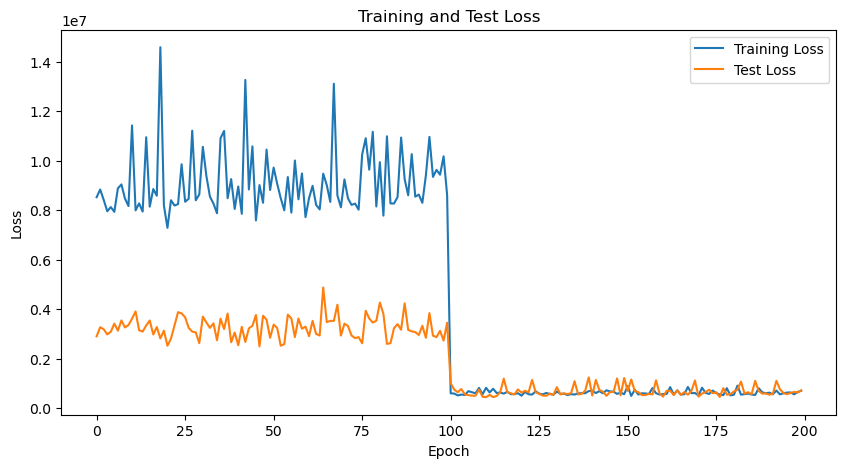

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

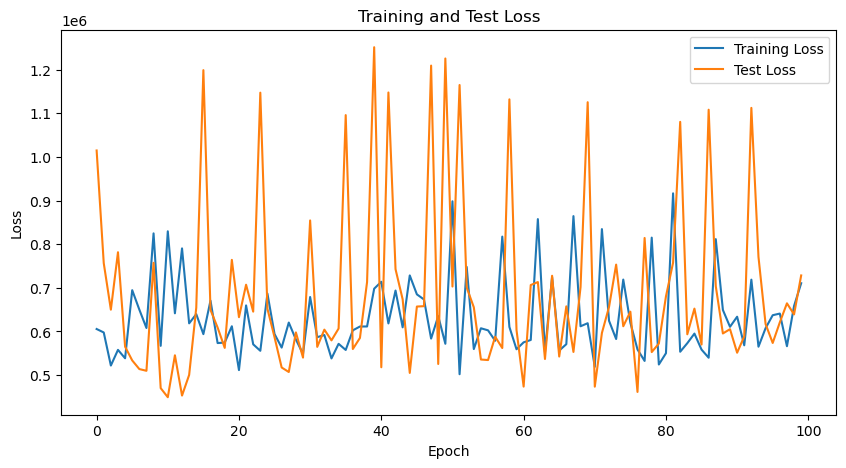

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(lstm_train_losses, label='Training Loss')
plt.plot(lstm_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Generate Node Embeddings with Best Model

In [33]:
# Initialize the model with the same arguments as the trained model
model = HeteroGNN(train_g, new_train_dims, common_dim=42, out_dim=42, agg_type='lstm')
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  

HeteroGNN(
  (node_transforms): ModuleDict(
    (customer): Linear(in_features=42, out_features=42, bias=True)
    (external): Linear(in_features=42, out_features=42, bias=True)
  )
  (gnn_layers): ModuleList(
    (0-1): 2 x HeteroGraphConv(
      (mods): ModuleDict(
        (cc_self): SAGEConv(
          (feat_drop): Dropout(p=0.1, inplace=False)
          (lstm): LSTM(42, 42, batch_first=True)
          (fc_neigh): Linear(in_features=42, out_features=42, bias=False)
          (fc_self): Linear(in_features=42, out_features=42, bias=True)
        )
        (cec): SAGEConv(
          (feat_drop): Dropout(p=0.1, inplace=False)
          (lstm): LSTM(42, 42, batch_first=True)
          (fc_neigh): Linear(in_features=42, out_features=42, bias=False)
          (fc_self): Linear(in_features=42, out_features=42, bias=True)
        )
        (cee): SAGEConv(
          (feat_drop): Dropout(p=0.1, inplace=False)
          (lstm): LSTM(42, 42, batch_first=True)
          (fc_neigh): Linear(in_fea

In [34]:
# Apply transformation to whole graph and get the new in_dims
new_g_fts = apply_transform(g)
new_g_fts

{'customer': tensor([[ -525.8912,   385.0594,  -158.3823,  ...,  -103.9524,  -767.7380,
             14.0343],
         [   13.4131,    20.7258,   -18.2366,  ...,   -17.3777,   -26.3557,
             -4.1672],
         [-3426.5581, -1609.0129,  3513.5515,  ...,   976.0396,  2553.9829,
           4102.6157],
         ...,
         [   15.2620,    22.7421,   -56.0457,  ...,   -48.5699,  -101.8715,
            -64.6957],
         [  142.6680,  -182.9664,  -110.1800,  ...,  -173.8490,    78.0142,
           -322.2863],
         [  -67.2352,    34.9635,    17.9244,  ...,    22.7592,   -58.1434,
            -61.2577]], grad_fn=<AddmmBackward0>),
 'external': tensor([[ 217.4209,  235.3573,   33.5766,  ...,  234.2415,   53.8519,
           -71.0787],
         [ 197.4887,  171.0712,   20.5097,  ...,   56.0696,  121.4947,
          -187.5149],
         [ 203.6861,  220.7253,   31.7750,  ...,  219.1276,   51.1602,
           -66.0461],
         ...,
         [  11.2604,  -10.4334,   38.0885,  ...

In [35]:
with torch.no_grad(): 
    embeddings = model(g, new_g_fts)

In [36]:
# Show the embeddings
embeddings

{'customer': tensor([[-1481.7013, -1973.0471,  -648.9993,  ...,   473.2238,  1901.7328,
             50.7098],
         [  -27.7733,   -32.8630,    24.9695,  ...,    -8.5909,    18.8338,
             39.1865],
         [  787.2355,   983.8456, -6305.7485,  ...,  3080.0137, -2446.7754,
          -1939.5363],
         ...,
         [ -188.9064,  -173.3874,   191.5622,  ...,   -15.9576,    43.2905,
            191.5436],
         [ -519.7206,   343.2340,   537.3835,  ...,  -296.0171,    87.5627,
            259.0995],
         [  -23.6525,  -311.8445,   -92.4059,  ...,    20.2786,   342.1154,
            -43.2994]]),
 'external': tensor([[ 1.6445e+02, -2.7517e+02,  2.5782e+02,  ...,  4.0220e+02,
          -4.8828e+01,  3.3879e+02],
         [ 2.3431e+02, -1.8187e+02,  4.3441e+02,  ...,  2.6884e+02,
           3.5669e+01,  3.8500e+02],
         [ 1.5340e+02, -2.5526e+02,  2.3894e+02,  ...,  3.7309e+02,
          -4.5782e+01,  3.1584e+02],
         ...,
         [ 7.5306e+01, -4.1333e+00,  

In [37]:
# save the embeddings so that we can use it for clustering in another notebook
torch.save(embeddings, 'embeddings.pt')
print("Embeddings saved successfully.")

Embeddings saved successfully.


# Limitations, Next Steps and Future Considerations

Due to constraints on time, we weren't able to test out many different types of convolutional layers as well as build a model that can incorporate edge features into its embeddings. Furthermore, after building our base model, we wanted to go back to re-implement feature selection through correlation analysis and feature importance, as well as add a feature normalization layer to the SAGEConv. 

Our next steps would be to work and fix areas we couldn't finish due to time constraints.

For future considerations, we can consider swapping out the SAGEConv layer with other layers such as EGATConv, which is a Graph Attention Layer that can handle edge features. The Graph Isomorphism Network with Edge Features (GINEConv) is another convolutional layer we considered implementing that is able to distinguish between different graph structures. The last convolutional layer we considered was the Heterogeneous Graph Transformer convolution (HGTConv) which incorporates an attention mechanism inspired by the Transformer model. 

In addition, we can explore additional changes to our analysis process. Instead of clustering the nodes in the Transactions graph with Leiden Modularity, we can input the graph into a GNN to extract embeddings that can capture more information about the relationships. We can then cluster the nodes based on those embeddings and continue the community analysis and feature extraction for the customers graph. After retrieving the embedded outputs for the GNN that uses the customer graph as input, we can cluster the customer nodes in to subgraphs, then further implement another GNN to produce embeddings for these subgraphs, which we can then further cluster into communities of subgraphs. Once we have these communities, we can then analyze the communities of subgraphs to try and identify a community of illegal wildlife traffickers and those involved in the process. 

# Final Notes

Overall, this project was a very great and fun opportunity to work with a large dataset to try and solve a complex real-world problem! We learned a lot about different types of graphs and machine learning methods that can be used on graphs, and how these methods can help us identify patterns in customer and transaction relationships.

Thank you for taking the time to look through our project, and we hope that you found our project interesting! Finally, we hope that our project can help provide additional ideas on how to identify illegal wildlife trafficking networks so that we can implement additional corresponding measures to reduce wild-life related crime. 